# Cart-Pole Q-Learning
Solving the cart-pole problem with Q-learning.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from src.QAgent import QAgent

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [10.0, 7.0]

In [4]:
%load_ext autoreload
%autoreload 2

## Hyperparameter Search
Perform a random hyperparameter search using ray tune.

The search space is sub-optimal (for instance, it includes the possibility of a
single angular bin, from which it is impossible to learn any kind of good
policy) but these features are left in to demonstrate the importance of sane
hyperparameter searching.

An 84-core-hour random search was performed, which yielded only a handful of
good policies. This could probably be greatly improved by using a 'smart'
optimisation strategy (e.g. hyperband, Bayesian) and/or removing coordinates
from the hyperparameter space that will obviously perform poorly (e.g. single
bins in angle, bins that don't allow for determination of small positive or
negative angular velocity, etc.) or are overly finely sampled (2 to 9 bin edges
is overkill).

Two metrics are used to evaluate the performance of an agent during training.
A higher value is better for both.
- `max_consecutive`: The maximum number of consecutive episodes that terminated
at 500 time steps.
- `max_split`: The learning curve is split into segments of (near-)equal number
of episodes and the average termination time step calculated. The maximum
average termination time step is reported.

A rolling window would be better than `max_split`, but I didn't think of this
before doing the hyperparameter search.

In [43]:
import ray
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune import ExperimentAnalysis

ray.init(num_cpus=6)

In [9]:
def max_consecutive_vec(arr, val):
    """Calculate maximum number of consecutive identical list entries using a
    vectorised algorithm.
    
    Parameters
    ----------
    arr : list
        List of integers.
    val : int
        The value to look for in the list.
    """
    arr = np.array(arr)
    arr[arr!=val] = 0
    arr[arr==val] = 1
    arr = np.concatenate(([0], arr, [0]))
    idx = np.flatnonzero(arr[1:] != arr[:-1])
    arr[1:][idx[1::2]] = idx[::2] - idx[1::2]
    max_consecutive = np.abs(np.min(arr))
    return max_consecutive


def evaluate_training(agent, segment_length):
    """Calculate some metrics.
    
    Parameters
    ----------
    agent : QAgent instance.
    segment_length : int
        Length of segment to divide steps into.
        
    Returns
    -------
    max_consecutive : int
        Maximum consecutive episodes that reached 500 steps.
    split_avg : float
        Maximum of the agerage steps in the step segments.
    """
    max_consecutive = max_consecutive_vec(agent.steps, 500)
    
    steps_split = np.array_split(agent.steps, len(agent.steps)//segment_length)
    split_avg = max(list(map(np.mean, steps_split)))    
    
    return max_consecutive, split_avg


def train_multiple_agents(agent_kwargs, n_agents):
    agents = []
    for _ in range(n_agents):
        agent = QAgent(progress_bars=False, **agent_kwargs)
        agent.train()
        agents.append(agent)
    return agents


def train_and_evaluate_agents(agent_kwargs, n_agents=5, segment_length=100):
    agents = []
    for _ in range(n_agents):
        agent = QAgent(progress_bars=False, **agent_kwargs)
        agent.train()
        agents.append(agent)
    
    max_consecutive_scores = []
    avg_split_scores = []
    for agent in agents:
        score = evaluate_training(agent, segment_length)
        max_consecutive_scores.append(score[0])
        avg_split_scores.append(score[1])
    
    max_consec = max(max_consecutive_scores)
    max_split = max(avg_split_scores)
    
    return max_consec, max_split


def trainable(config):
    max_consec, max_split = train_and_evaluate_agents(config)
    tune.report(max_consecutive=max_consec, max_split=max_split)


def tune_hps():
    config = {
        'n_bins_pos': tune.randint(2, 9),
        'n_bins_vel': tune.randint(2, 9),
        'n_bins_ang': tune.randint(2, 9),
        'n_bins_ang_vel': tune.randint(2, 9),
        'lr_decay': tune.lograndint(5, 50),
        'eps_decay': tune.lograndint(5, 50),
        'discount_factor': tune.uniform(0.5, 0.99),
        'n_episodes': tune.randint(500, 2000)
    }
    reporter = JupyterNotebookReporter(
        overwrite=True,
        metric='max_consecutive',
        sort_by_metric=True,
        mode='max',
        print_intermediate_tables=True
    )

    # This errors out for some reason, but the data is still
    # saved to the ray_results directory.
    analysis = tune.run(
        trainable,
        config=config,
        num_samples=-1,
        time_budget_s=50400,  # 14 hrs
        progress_reporter=reporter
    )

In [10]:
# Uncomment below and run to perform the hp scan

# tune_hps()

In [44]:
analysis = ExperimentAnalysis('~/ray_results/trainable_2022-05-24_18-19-31')
df_analysis = analysis.results_df
df_analysis = df_analysis.dropna(subset='max_consecutive')
df_analysis

2022-05-27 14:50:29,479	INFO experiment_analysis.py:748 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
/Users/george.holt/miniforge3/envs/q-learning-cart-pole-main/lib/python3.9/site-packages/ray/tune/analysis/experiment_analysis.py:301: UserWarning: Dataframes will use '/' instead of '.' to delimit nested result keys in future versions of Ray. For forward compatibility, set the environment variable TUNE_RESULT_DELIM='/'
  warnings.warn(


,max_consecutive,max_split,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,...,warmup_time,experiment_tag,config.n_bins_pos,config.n_bins_vel,config.n_bins_ang,config.n_bins_ang_vel,config.lr_decay,config.eps_decay,config.discount_factor,config.n_episodes
trial_id,,,,,,,,,,,,,,,,,,,,,
acdbc_00010,1.0,34.168224,5.596027,True,NaN,NaN,1.0,6fe0b8117e1f4327b84e257d87084646,2022-05-24_18-20-00,1.653413e+09,...,0.002571,"10_discount_factor=0.98175,eps_decay=9,lr_deca...",5.0,3.0,7.0,6.0,35.0,9.0,0.981753,1178.0
acdbc_00000,5.0,278.326733,36.347309,True,NaN,NaN,1.0,435762c963f6436cbced331d242883c6,2022-05-24_18-20-11,1.653413e+09,...,0.002092,"0_discount_factor=0.52066,eps_decay=47,lr_deca...",8.0,2.0,5.0,6.0,5.0,47.0,0.520665,1414.0
acdbc_00006,0.0,20.106796,3.521015,True,NaN,NaN,1.0,ce1021368b86449da6e8abd921af816c,2022-05-24_18-19-48,1.653413e+09,...,0.005079,"6_discount_factor=0.69507,eps_decay=21,lr_deca...",4.0,5.0,6.0,8.0,38.0,21.0,0.695068,613.0
acdbc_00009,0.0,46.314286,9.744616,True,NaN,NaN,1.0,57db25e16f864044b60a8437383c2f4d,2022-05-24_18-20-01,1.653413e+09,...,0.002766,"9_discount_factor=0.69053,eps_decay=7,lr_decay...",6.0,7.0,3.0,3.0,40.0,7.0,0.690530,1366.0
acdbc_00013,0.0,15.750000,2.514686,True,NaN,NaN,1.0,da1c34aec34648c0ad2b9141268d28d1,2022-05-24_18-20-09,1.653413e+09,...,0.003154,"13_discount_factor=0.58134,eps_decay=13,lr_dec...",4.0,8.0,6.0,5.0,37.0,13.0,0.581338,622.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
acdbc_14206,1.0,134.318182,14.904297,True,NaN,NaN,1.0,9898eff05f304e5ba6f5ced3c4e5aaf3,2022-05-25_08-19-32,1.653463e+09,...,0.002800,"14206_discount_factor=0.92763,eps_decay=33,lr_...",3.0,3.0,5.0,3.0,8.0,33.0,0.927626,548.0
acdbc_14203,0.0,43.079208,6.431562,True,NaN,NaN,1.0,ed39e558b9d74814b198265fe353b2df,2022-05-25_08-19-13,1.653463e+09,...,0.003316,"14203_discount_factor=0.72144,eps_decay=5,lr_d...",2.0,3.0,7.0,8.0,5.0,5.0,0.721439,1008.0
acdbc_14204,0.0,22.528302,3.382459,True,NaN,NaN,1.0,e58b94b443684a98893571ce13dd4c2a,2022-05-25_08-19-17,1.653463e+09,...,0.003568,"14204_discount_factor=0.8093,eps_decay=40,lr_d...",6.0,5.0,7.0,2.0,46.0,40.0,0.809301,842.0


In [57]:
config_strs = [i for i in df_analysis.columns if i.startswith('config')]
metric_strs = ['max_split', 'max_consecutive']
config_and_metric_strs = config_strs.copy()
config_and_metric_strs.extend(metric_strs)
print(config_strs)
print(metric_strs)
print(config_and_metric_strs)

['config.n_bins_pos', 'config.n_bins_vel', 'config.n_bins_ang', 'config.n_bins_ang_vel', 'config.lr_decay', 'config.eps_decay', 'config.discount_factor', 'config.n_episodes']
['max_split', 'max_consecutive']
['config.n_bins_pos', 'config.n_bins_vel', 'config.n_bins_ang', 'config.n_bins_ang_vel', 'config.lr_decay', 'config.eps_decay', 'config.discount_factor', 'config.n_episodes', 'max_split', 'max_consecutive']


<AxesSubplot:xlabel='max_consecutive', ylabel='max_split'>

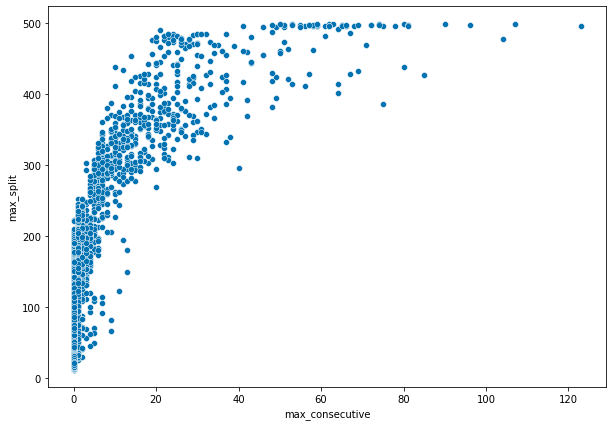

In [50]:
sns.scatterplot(data=df_analysis, x='max_consecutive', y='max_split')

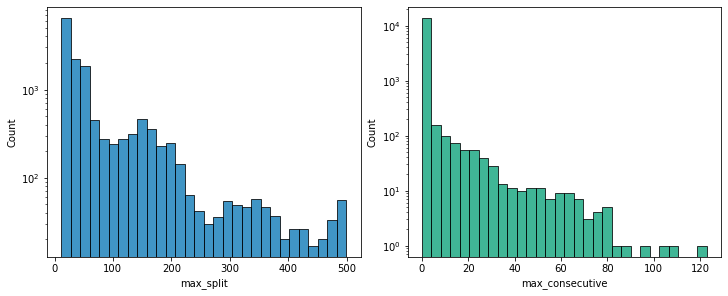

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 4))
sns.histplot(data=df_analysis, x='max_split', bins=30, ax=ax1, color='C0')
sns.histplot(data=df_analysis, x='max_consecutive', bins=30, ax=ax2, color='C1')
ax1.set_yscale('log')
ax2.set_yscale('log')

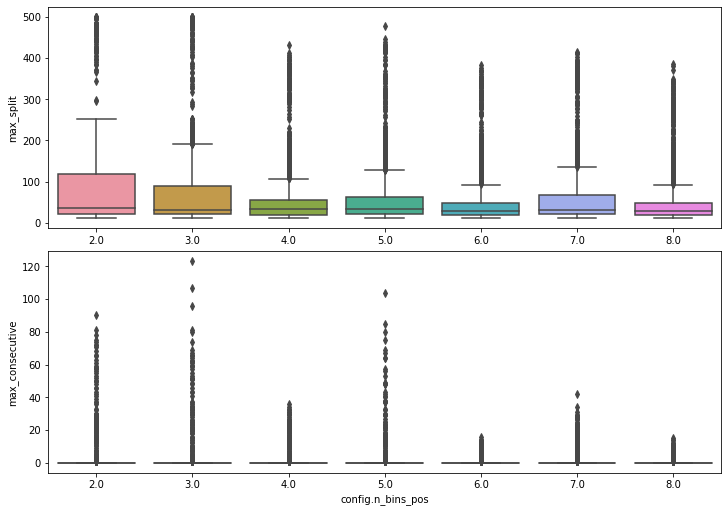

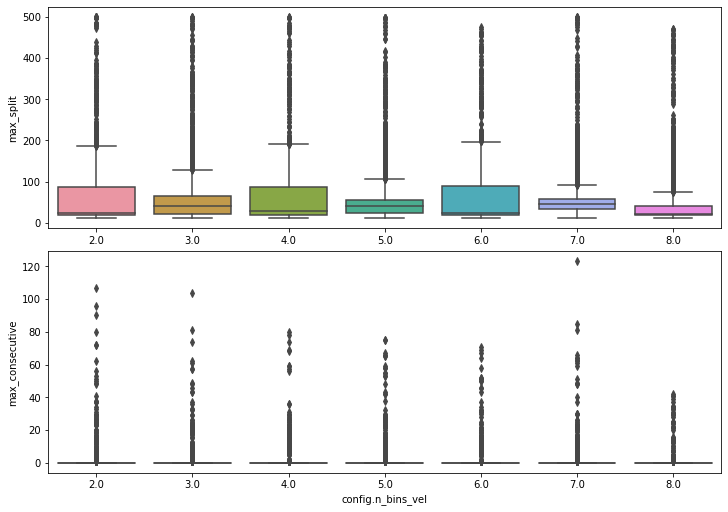

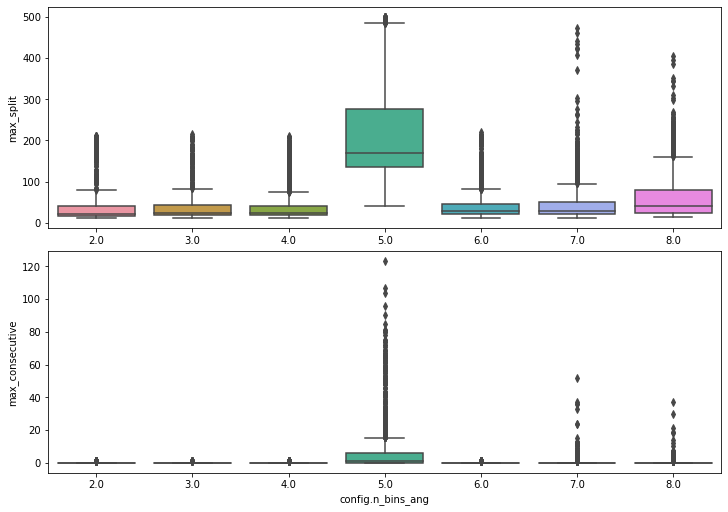

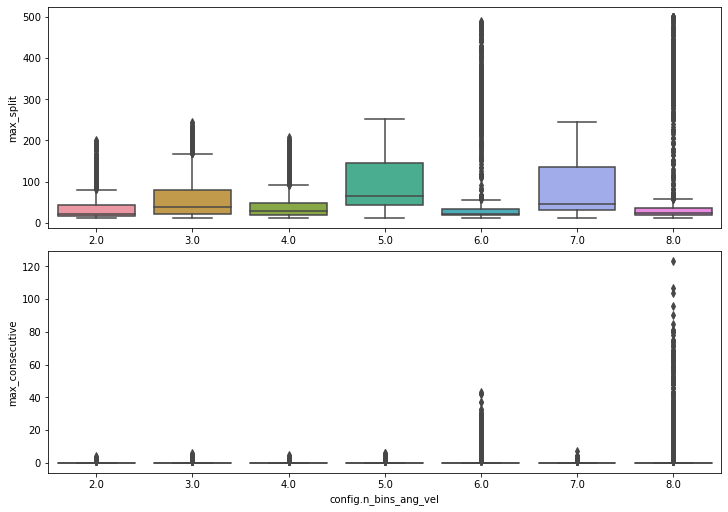

In [51]:
def boxplots(hp):
    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
    sns.boxplot(data=df_analysis, x=hp, y='max_split', ax=ax1)
    sns.boxplot(data=df_analysis, x=hp, y='max_consecutive', ax=ax2)
    ax1.set_xlabel(None)

for hp in config_strs[:4]:
    boxplots(hp)


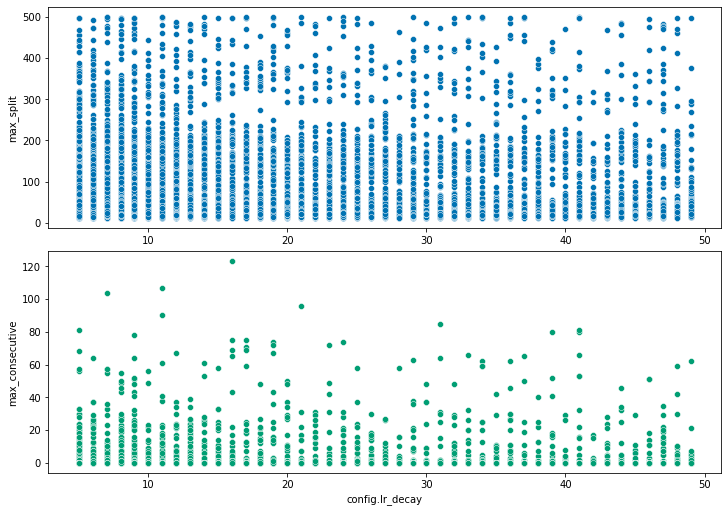

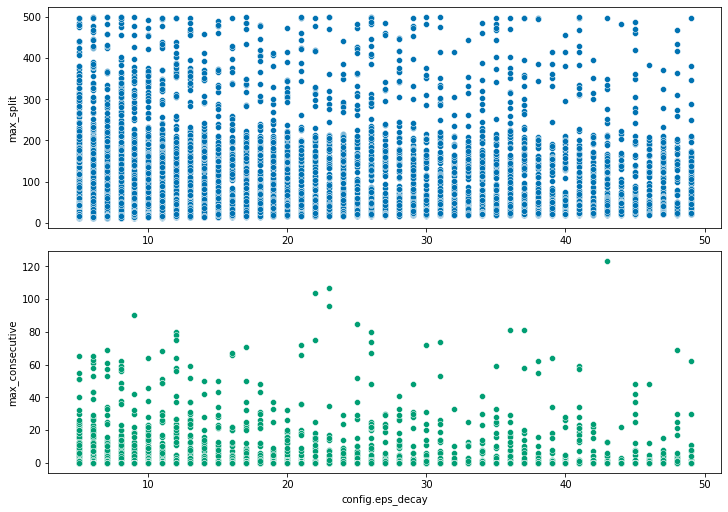

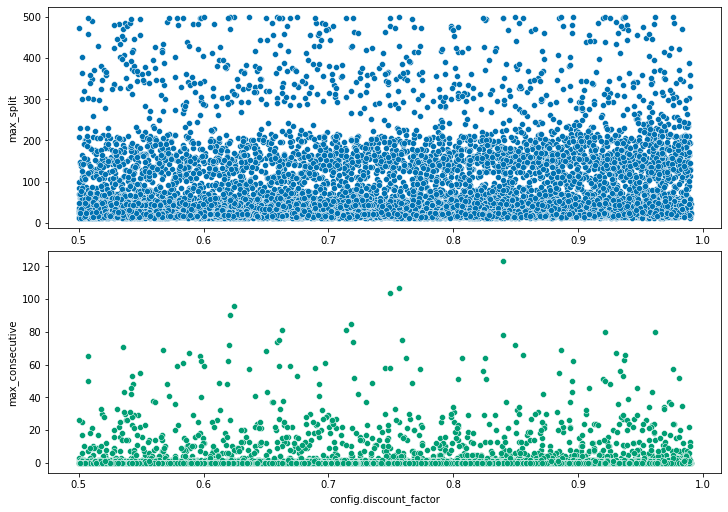

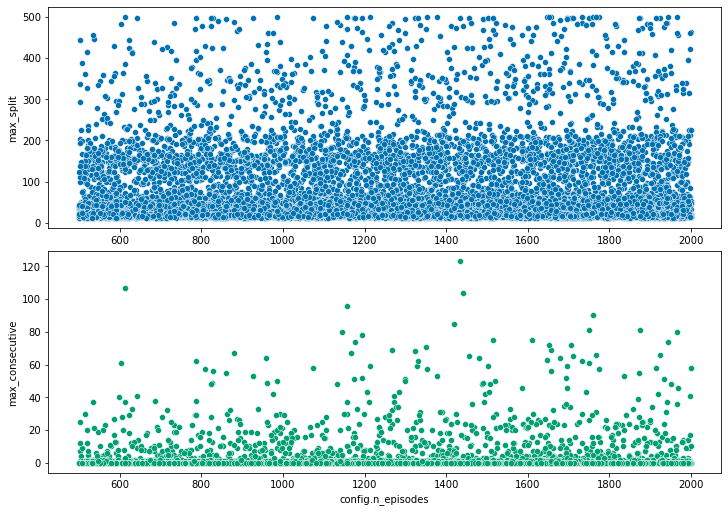

In [67]:
def scatter(hp):
    fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True)
    sns.scatterplot(data=df_analysis, x=hp, y='max_split', ax=ax1, color='C0')
    sns.scatterplot(data=df_analysis, x=hp, y='max_consecutive', ax=ax2, color='C1')
    ax1.set_xlabel(None)

for hp in config_strs[4:]:
    scatter(hp)

In [58]:
corr_matrix = df_analysis[config_and_metric_strs].corr(method='spearman')
print(corr_matrix['max_consecutive'].sort_values(ascending=False))
print('\n')
print(corr_matrix['max_split'].sort_values(ascending=False))

max_consecutive           1.000000
max_split                 0.565673
config.n_bins_ang_vel     0.160267
config.n_bins_ang         0.093875
config.discount_factor    0.081085
config.n_episodes         0.041791
config.eps_decay          0.025551
config.n_bins_vel        -0.032743
config.lr_decay          -0.034607
config.n_bins_pos        -0.052501
Name: max_consecutive, dtype: float64


max_split                 1.000000
max_consecutive           0.565673
config.n_bins_ang         0.234039
config.eps_decay          0.142155
config.discount_factor    0.123971
config.n_bins_ang_vel     0.086974
config.n_episodes         0.032517
config.n_bins_vel         0.003133
config.n_bins_pos        -0.046640
config.lr_decay          -0.102928
Name: max_split, dtype: float64


## Best agent

In [54]:
# Train...
# agent_best = QAgent(
#     track_Q_tables=True,
#     **analysis.get_best_config(metric='max_split', mode='max')
# )
# agent_best.train()

# ...or load
agent_best = QAgent(Q_table_path='./Q-tables/best.npy')

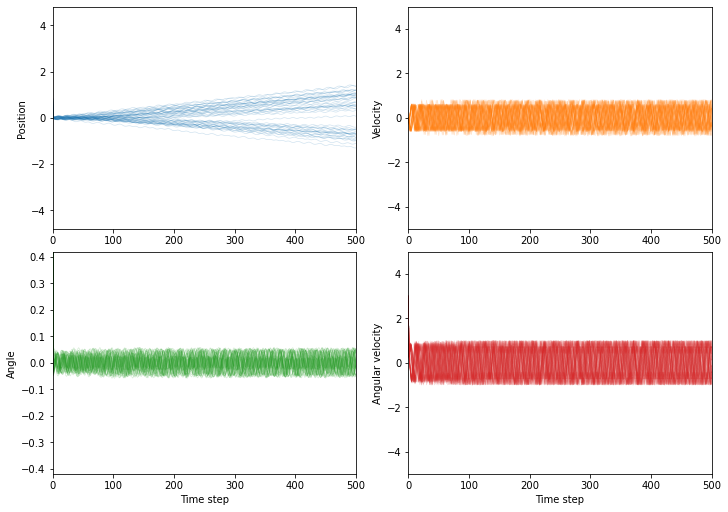

In [55]:
alpha = 0.2
for i in range(50):
    agent_best.run_agent(render=False)
    if i == 0:
        fig, axs = agent_best.plot_states(alpha=alpha)
    else:
        agent_best.plot_states(axs, alpha=alpha)